In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import mudata as md
import os
import sys
import pooch
import scanpy as sc
import leidenalg
import scanpy.external as sce
import matplotlib.pyplot as plt
import muon as mu
from muon import prot as pt

/data/msun/miniconda3/envs/CITE/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Filter out warnings to minimize clutter
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [6]:
import sys
sys.path.append('/data/msun/projects/Stephen/PDAC_scRNA/')
from core_functions.difference import *

In [7]:
sc.settings.n_jobs = -1

In [8]:
mdata = mu.read('/data/msun/projects/Stephen/PDAC_scRNA/01_process_annnotate/annotated_citeseq_nospleen.h5mu')

In [9]:
mdata

MuData object with n_obs × n_vars = 6547 × 55632
  obs:	'HT1', 'HT2', 'HT3', 'HT4', 'HT5', 'HT6', 'HT7', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'sample', 'condition', 'leiden'
  var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
  obsm:	'X_mofa', 'X_umap', 'X_umap_mofa'
  varm:	'LFs'
  obsp:	'connectivities', 'distances'
  2 modalities
    rna:	6547 x 55487
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltype_V1', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'DEG_leiden_res0_25', 'celltype_V1_colors', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_fine_colors', 'condition_colors', 'dendrogram_leiden_res0_25', 'hvg', 'leiden_colors', 'leiden_res0_25', 'leiden_res0_25_colors', 'leiden_res0_5', 'leiden_res0_5_colors', 'leiden_res0_75', 'leiden_res0_75_colors', 'leiden_res1', 'leiden_res1_colors', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log1p_norm', 'magiced', 'scaled'
      obsp:	'connectivities', 'distances'
    prot:	6547 x 145
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublets_markers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'Classification_colors', 'doublets_markers_colors', 'leiden_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'

In [10]:
mdata.obs['sample'].value_counts()

sample
LFD_1             1825
Soy_1             1743
LFD_2             1487
Fish_1             935
Soy_2              487
Fish_2              70
Spleen control       0
Name: count, dtype: int64

In [11]:
mdata.obs['condition'].value_counts()

condition
LFD               3312
Soy               2230
Fish              1005
Spleen control       0
Name: count, dtype: int64

In [12]:
mdata.mod["rna"].obs["condition"] = mdata.obs["condition"]
mdata.mod["rna"].obs["sample"] = mdata.obs["sample"]

In [13]:
rna = mdata.mod["rna"]

In [9]:
rna.write("/data/msun/projects/Stephen/PDAC_scRNA/01_process_annnotate/annotated_rna_nospleen.h5ad")

## all cells by sample 

DataFrame saved to /data/msun/projects/Stephen/PDAC_scRNA/02_difference/cell_distribution/celltype_bysample_3.csv


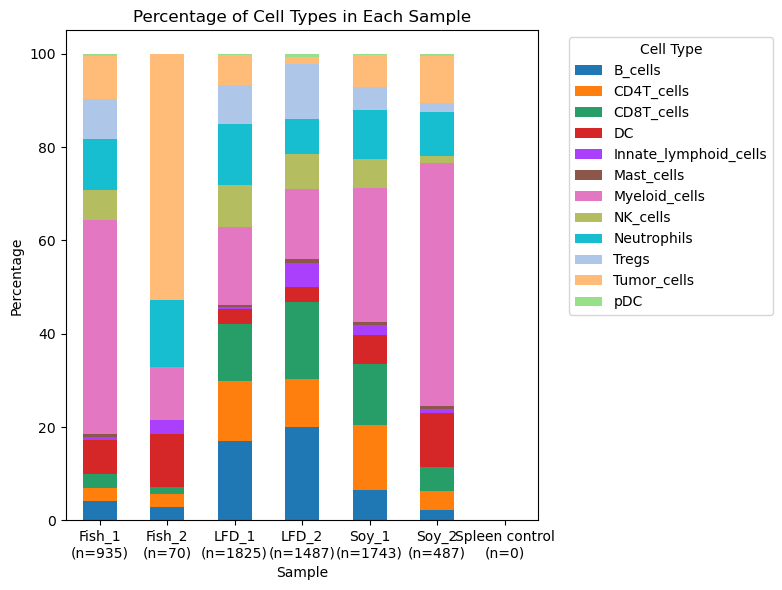

In [10]:
distribution_stackedbar(rna,"sample","celltype_V1")

In [11]:
df = pd.DataFrame(rna.obs)
count_df = df.groupby(["condition", "celltype_V1"]).size().unstack(fill_value=0)

In [12]:
sample_col="condition"

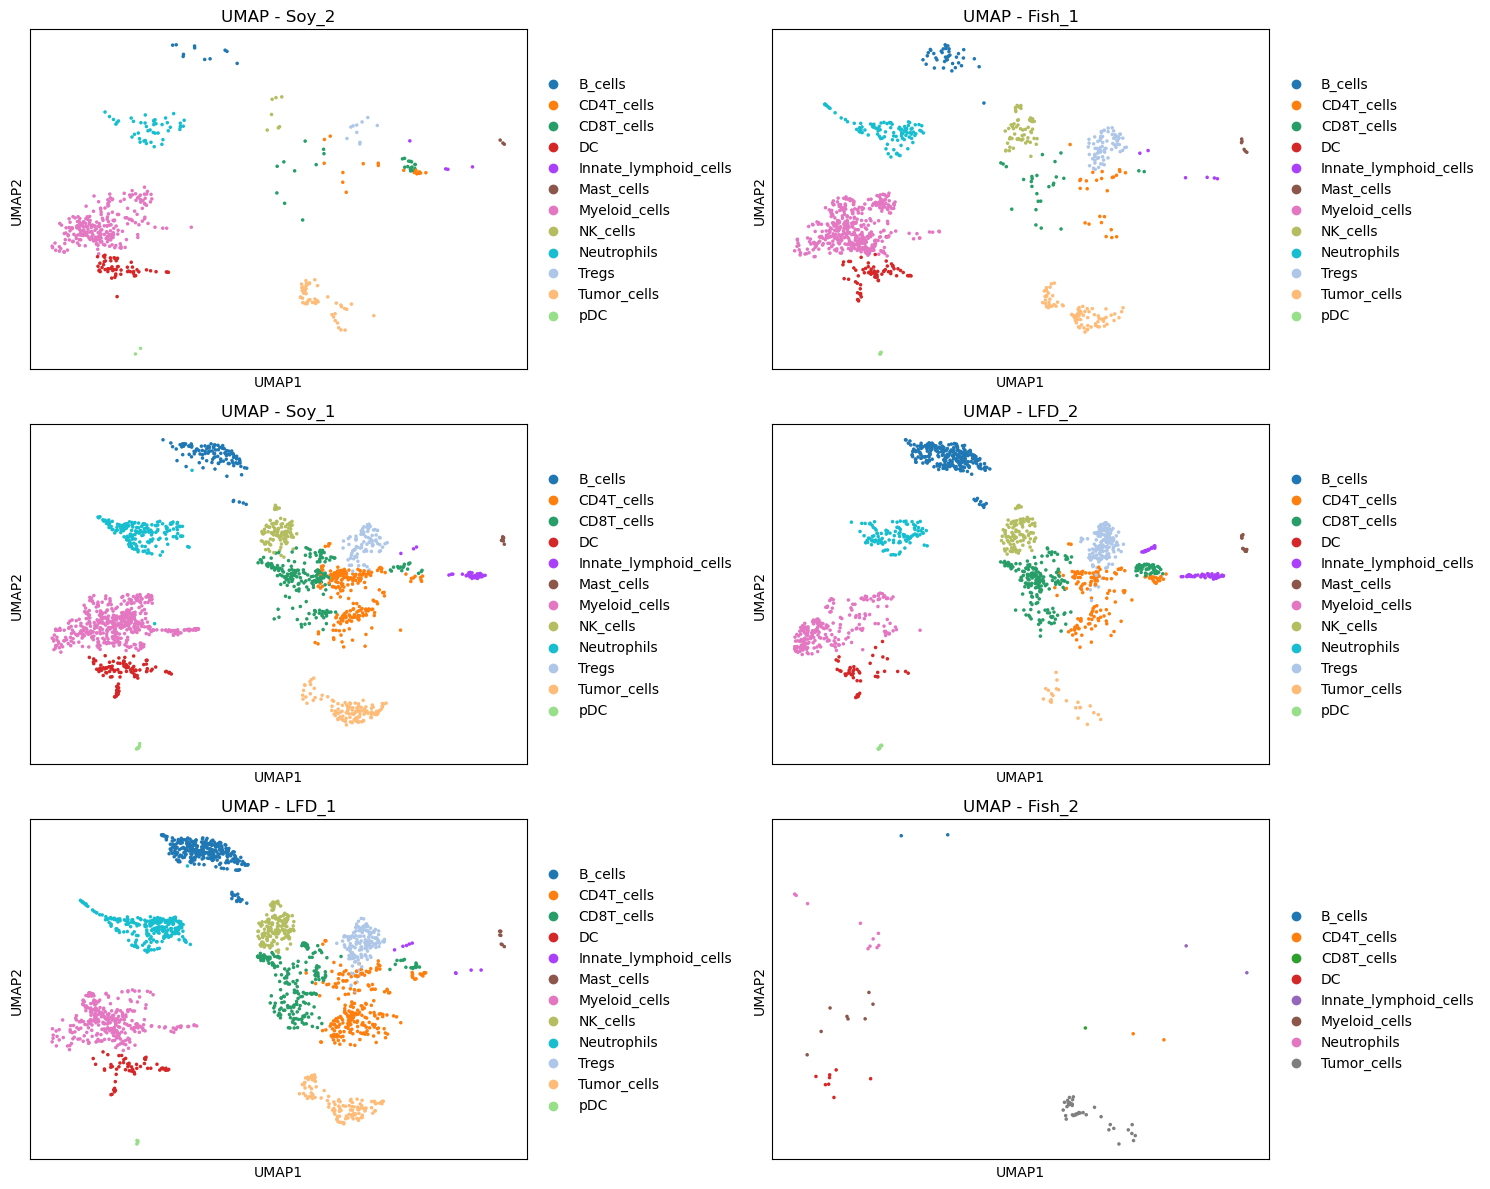

In [13]:
split_plots(rna,n_cols=2)

## all cells by condtion

In [20]:
def distribution_barplot(adata, cell_type_col, condition_col,figsize=(14, 7), bar_width=0.3):
    """
    Plots the percentage of each cell type under different conditions with custom colors.
    
    Parameters:
    adata (AnnData): The AnnData object containing the single-cell data.
    cell_type_col (str): The column name in adata.obs that contains cell type information.
    condition_col (str): The column name in adata.obs that contains condition information.
    condition_colors (dict): A dictionary mapping conditions to their respective colors.
    
    Returns:
    None
    """
    # Calculate total cells per condition
    total_cells_per_condition = adata.obs.groupby(condition_col).size()
    
    # Calculate cell counts per cell type and condition
    cell_counts = adata.obs.groupby([cell_type_col, condition_col]).size().unstack(fill_value=0)
    
    # Calculate percentages
    cell_type_percentages = cell_counts.div(total_cells_per_condition, axis=1) * 100
    
    # Plotting
    fig, ax = plt.subplots(figsize= figsize) 
    #colors = ["#E8AECB","#263260","#D6C685","#FFFFFF"]
    colors = ["#E8AECB","#263260","#A3C6B5","#FFFFFF"]
    index = np.arange(len(cell_type_percentages))

    for i, condition in enumerate(cell_type_percentages.columns):
        ax.bar(index + i * bar_width, cell_type_percentages[condition], 
               bar_width, label=condition, color=colors[i])

    ax.set_xlabel('Cell Type')
    ax.set_ylabel('Percentage of cell number by total cell number under one condition')
    ax.set_title('Cell Type Distribution Across Conditions')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(cell_type_percentages.index, rotation=45, ha='right')
    ax.legend(title='Condition')

    plt.tight_layout()
    plt.show()

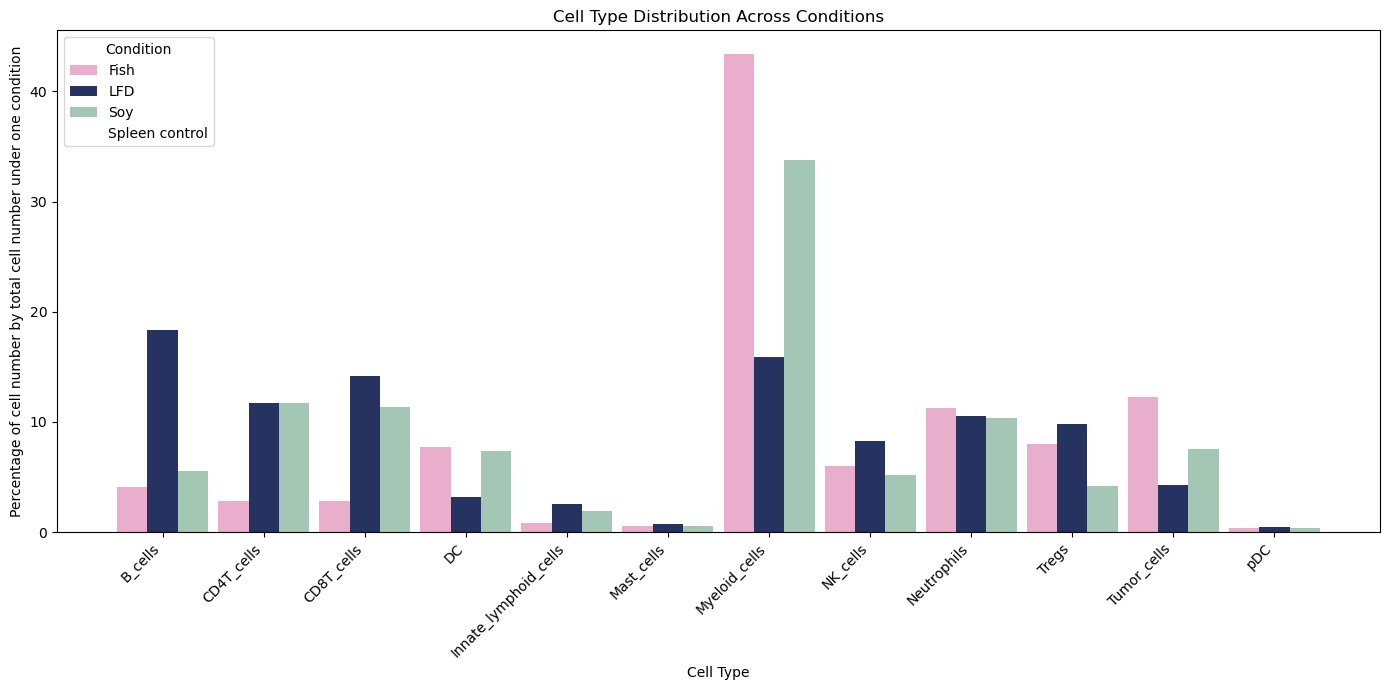

In [21]:
distribution_barplot(rna,"celltype_V1","condition")
# NCD 
# HFD-Soy(n-6)
# HFD-Fish(n-3)

DataFrame saved to /data/msun/projects/Stephen/PDAC_scRNA/02_difference/cell_distribution/celltype_bycondition_6.csv


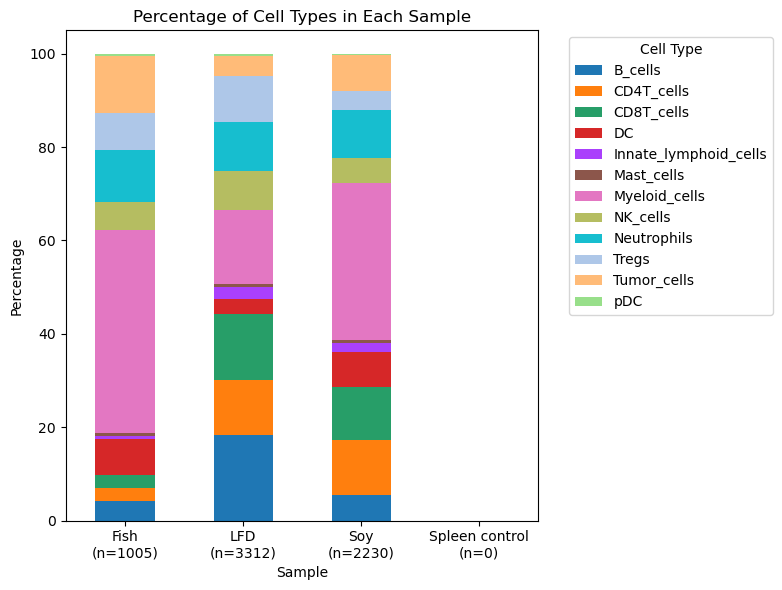

In [15]:
distribution_stackedbar(rna, sample_col = "condition")

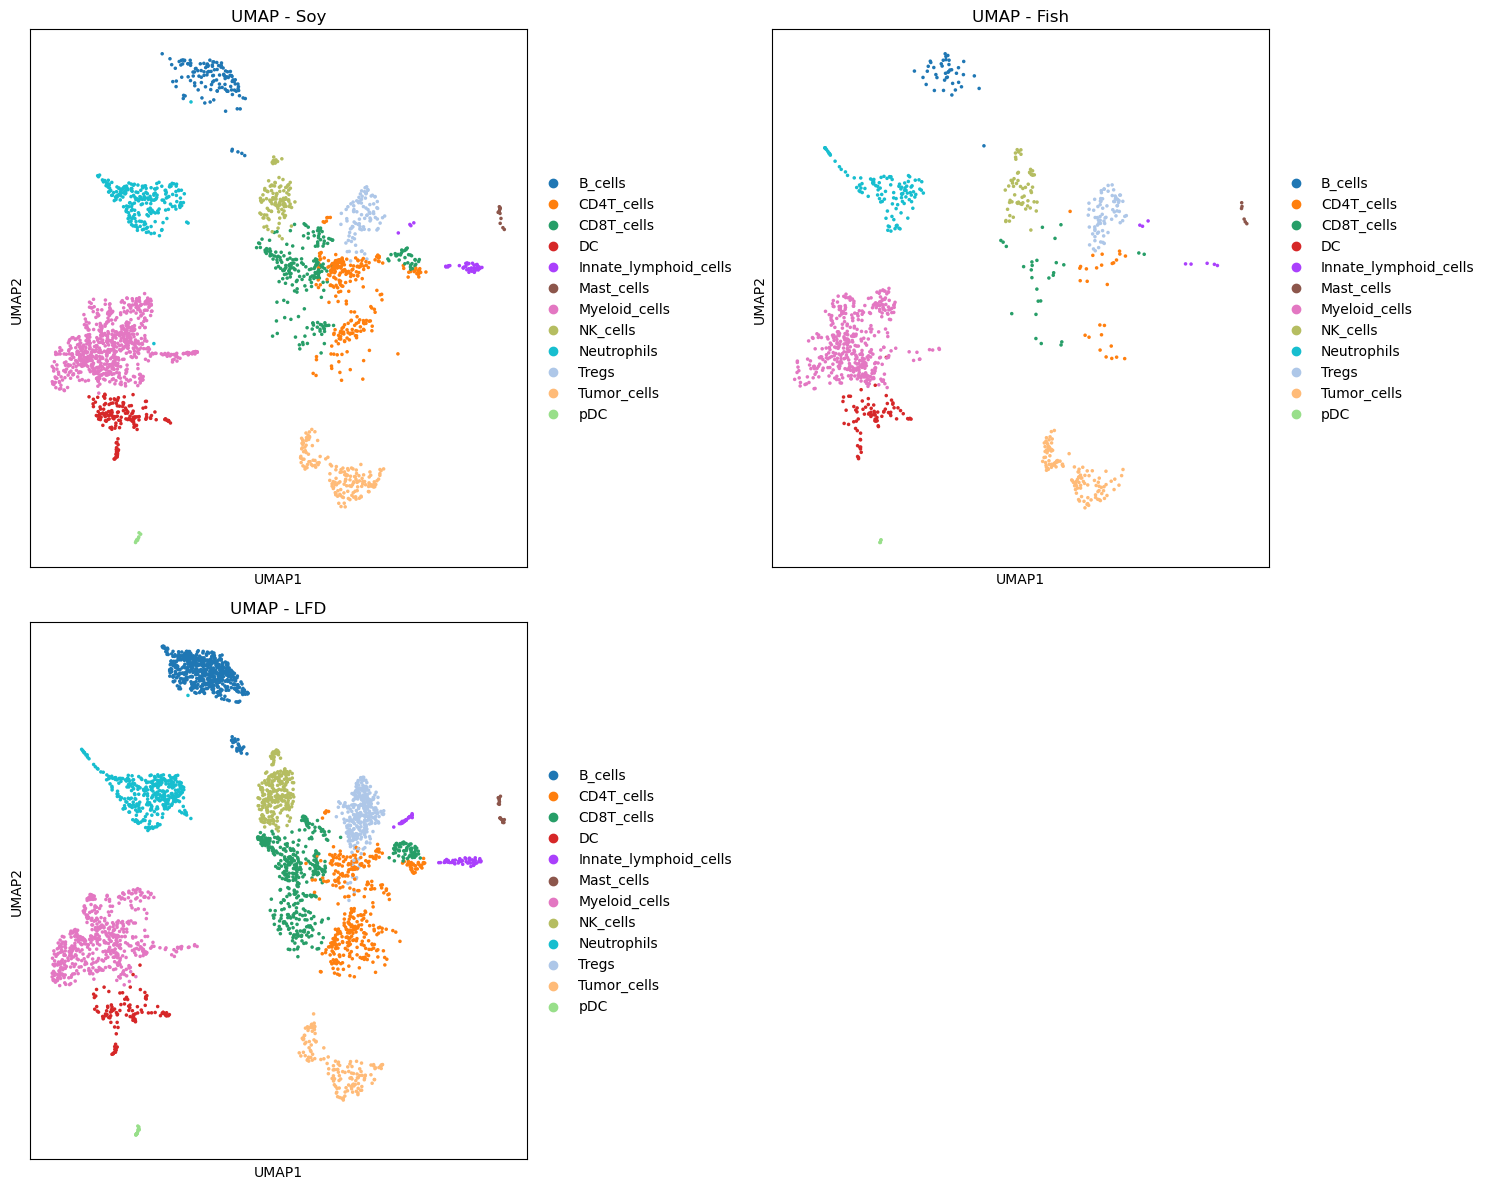

In [16]:
split_plots(rna, n_cols=2, sample_col = "condition")

## t cells by condtion 

In [38]:
tmdata = mu.read('/data/msun/projects/Stephen/PDAC_scRNA/01_process_annnotate/annotated_citeseq_nospleen_cd8t.h5mu')

In [39]:
tmdata

MuData object with n_obs × n_vars = 750 × 55632
  obs:	'HT1', 'HT2', 'HT3', 'HT4', 'HT5', 'HT6', 'HT7', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'sample', 'condition', 'leiden'
  var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
  obsm:	'X_mofa', 'X_umap', 'X_umap_mofa'
  varm:	'LFs'
  obsp:	'connectivities', 'distances'
  2 modalities
    rna:	750 x 55487
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltype_V1', 't_leiden_res0_25', 't_leiden_res0_5', 't_leiden_res0_75', 't_leiden_res1', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine', 'Tcelltype_V1'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'DEG_leiden_res0_25', 'DEG_leiden_res0_5', 'DEG_leiden_res0_75', 'Tcelltype_V1_colors', 'celltype_V1_colors', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_fine_colors', 'condition_colors', 'dendrogram_leiden_res0_25', 'dendrogram_t_leiden_res0_5', 'dendrogram_t_leiden_res0_75', 'hvg', 'leiden_colors', 'leiden_res0_25', 'leiden_res0_25_colors', 'leiden_res0_5', 'leiden_res0_5_colors', 'leiden_res0_75', 'leiden_res0_75_colors', 'leiden_res1', 'leiden_res1_colors', 'log1p', 'neighbors', 'pca', 't_leiden_res0_25', 't_leiden_res0_25_colors', 't_leiden_res0_5', 't_leiden_res0_5_colors', 't_leiden_res0_75', 't_leiden_res0_75_colors', 't_leiden_res1', 't_leiden_res1_colors', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log1p_norm', 'magiced', 'scaled'
      obsp:	'connectivities', 'distances'
    prot:	750 x 145
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublets_markers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'Classification_colors', 'doublets_markers_colors', 'leiden_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'

In [40]:
tmdata.mod["rna"].obs["condition"] = tmdata.obs["condition"]
tmdata.mod["rna"].obs["sample"] = tmdata.obs["sample"]

In [41]:
trna = tmdata.mod["rna"]

In [42]:
trna.write("/data/msun/projects/Stephen/PDAC_scRNA/01_process_annnotate/annotated_rna_nospleen_cd8t.h5ad")

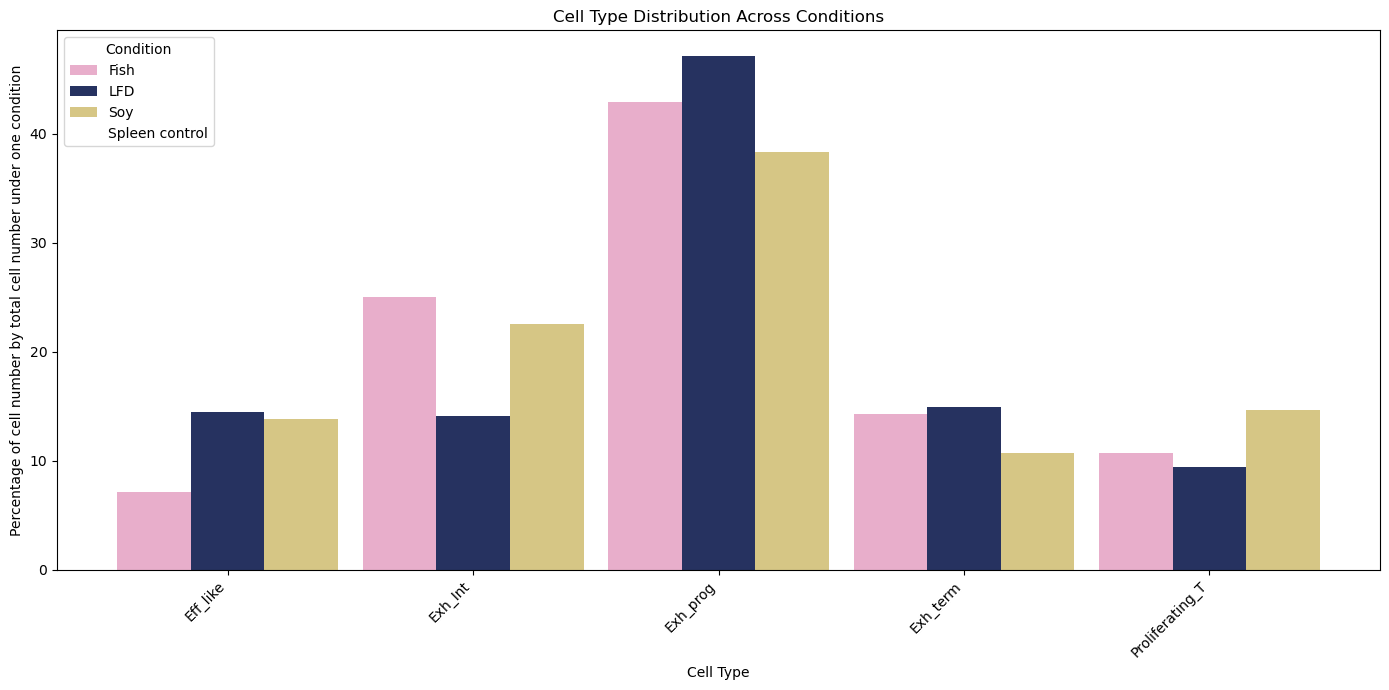

In [43]:
distribution_barplot(trna,"Tcelltype_V1","condition")

DataFrame saved to /data/msun/projects/Stephen/PDAC_scRNA/02_difference/cell_distribution/celltype_bycondition_9.csv


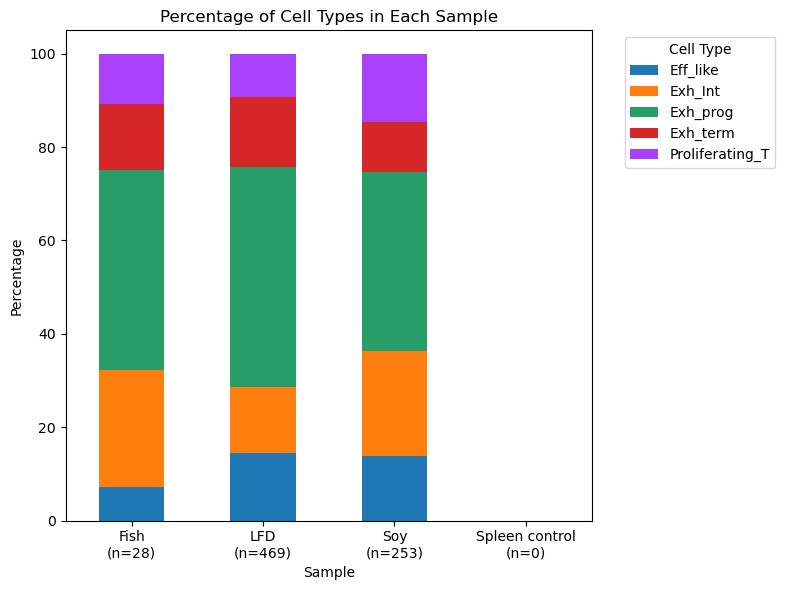

In [44]:
distribution_stackedbar(trna, sample_col = "condition",celltype_col = "Tcelltype_V1")

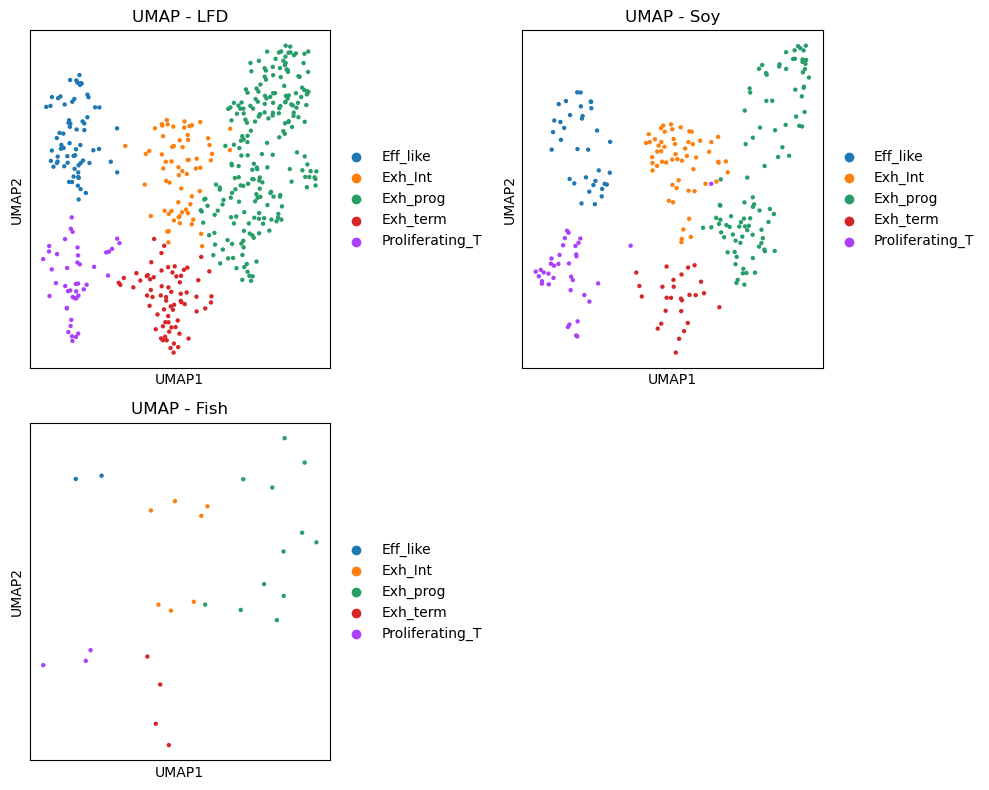

In [45]:
split_plots(trna, n_cols=2, sample_col = "condition",celltype_col = "Tcelltype_V1",ptsize=40,figsize=(10, 8))

## tam(celltype_V1) by condition

In [25]:
tammdata = mu.read('/data/msun/projects/Stephen/PDAC_scRNA/01_process_annnotate/annotated_citeseq_nospleen_tam.h5mu')

In [26]:
tammdata.mod["rna"].obs["condition"] = tammdata.obs["condition"]
tammdata.mod["rna"].obs["sample"] = tammdata.obs["sample"]

In [27]:
tamrna = tammdata.mod["rna"]

In [28]:
tamrna

AnnData object with n_obs × n_vars = 1716 × 55487
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltype_V1', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine', 'tam_leiden_res0_25', 'tam_leiden_res0_5', 'tam_leiden_res0_75', 'tam_leiden_res1', 'TAMcelltype_V1', 'TAMcelltype_V2', 'condition', 'sample'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'DEG_leiden_res0_25', 'DEG_leiden_res0_75', 'TAMcelltype_V1_colors', 'TAMcelltype_V2_colors', 'celltypist

In [29]:
tamrna.write("/data/msun/projects/Stephen/PDAC_scRNA/01_process_annnotate/annotated_rna_nospleen_tam.h5ad")

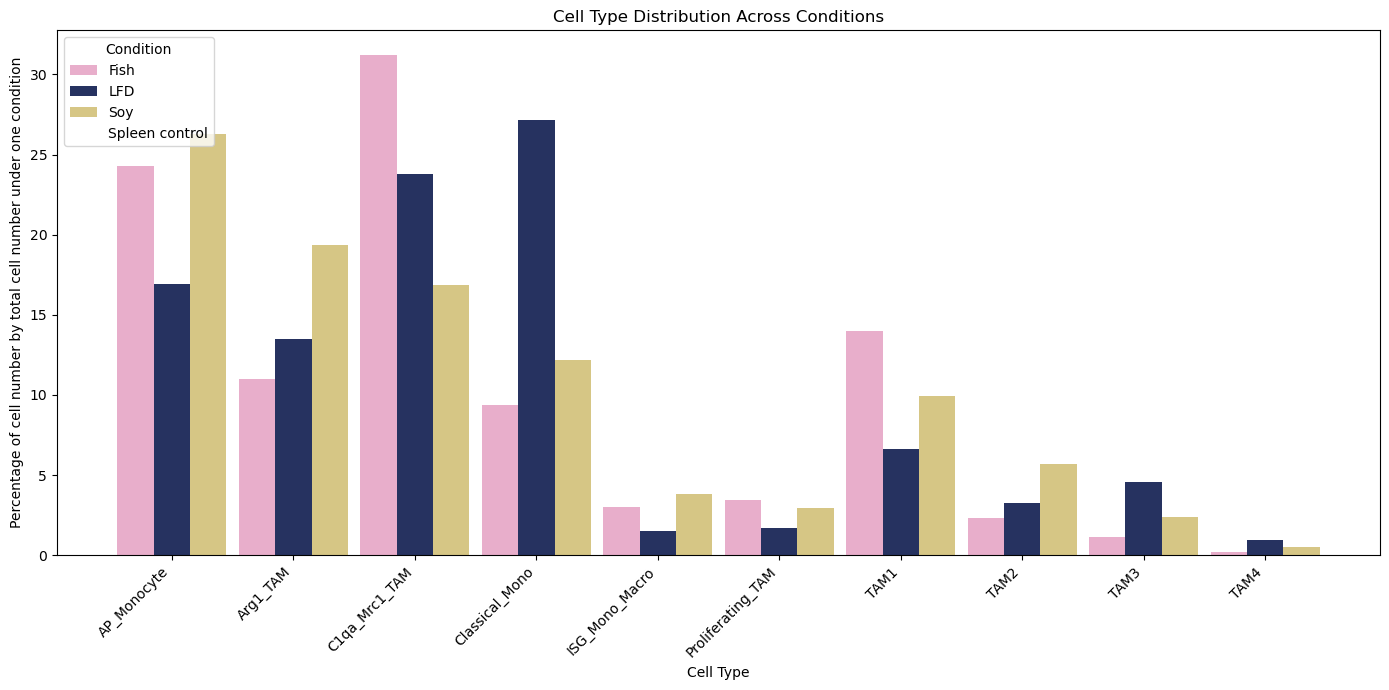

In [30]:
distribution_barplot(tamrna,"TAMcelltype_V1","condition")

DataFrame saved to /data/msun/projects/Stephen/PDAC_scRNA/02_difference/cell_distribution/celltype_bycondition_8.csv


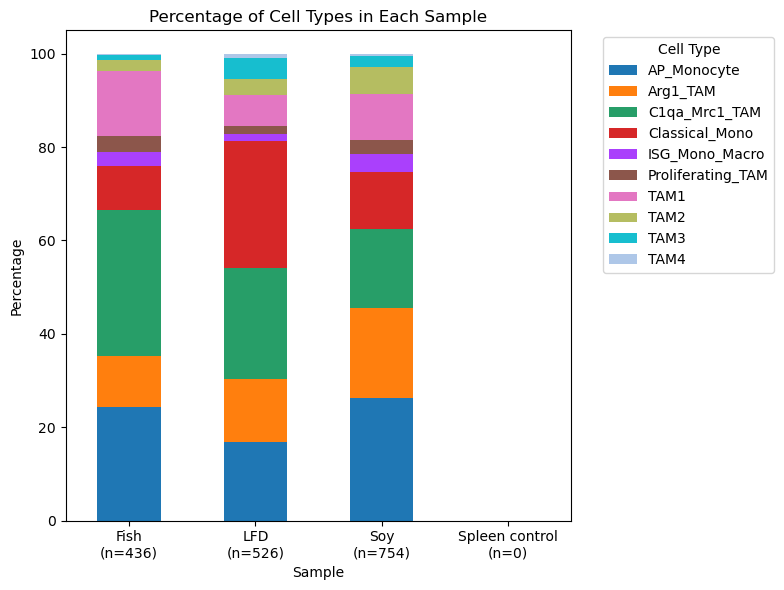

In [31]:
distribution_stackedbar(tamrna, sample_col = "condition",celltype_col = "TAMcelltype_V1")

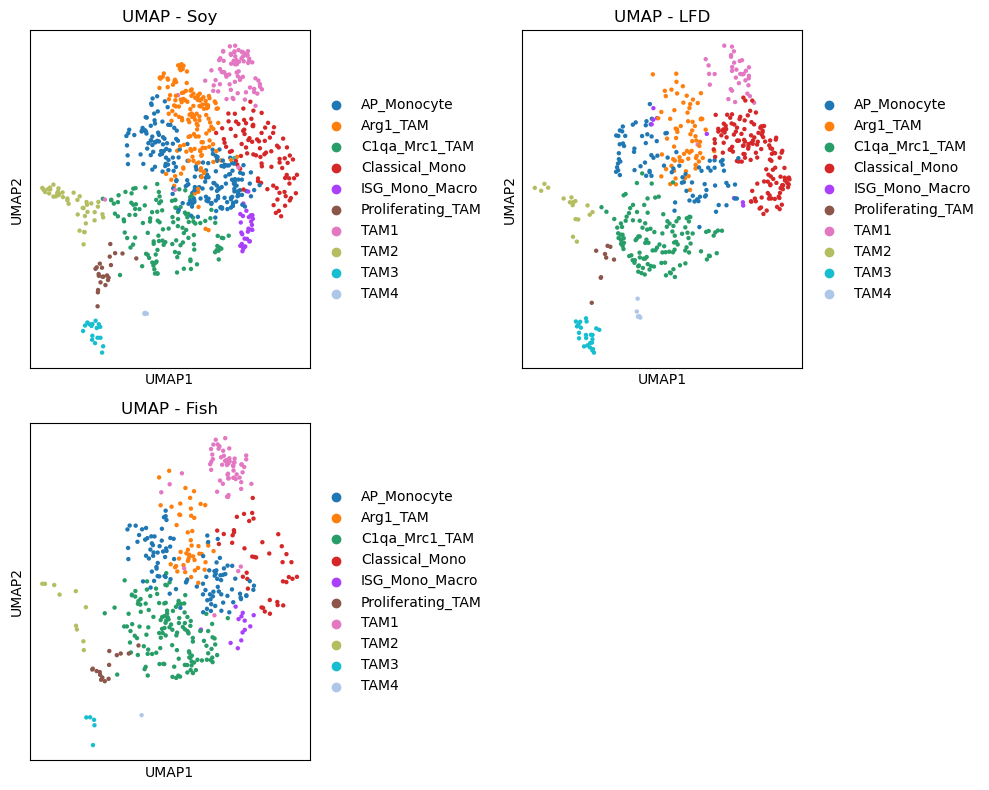

In [32]:
split_plots(tamrna, n_cols=2, sample_col = "condition",celltype_col = "TAMcelltype_V1",ptsize=40,figsize=(10, 8))

#### 

# tam (celltype_V2) by condition

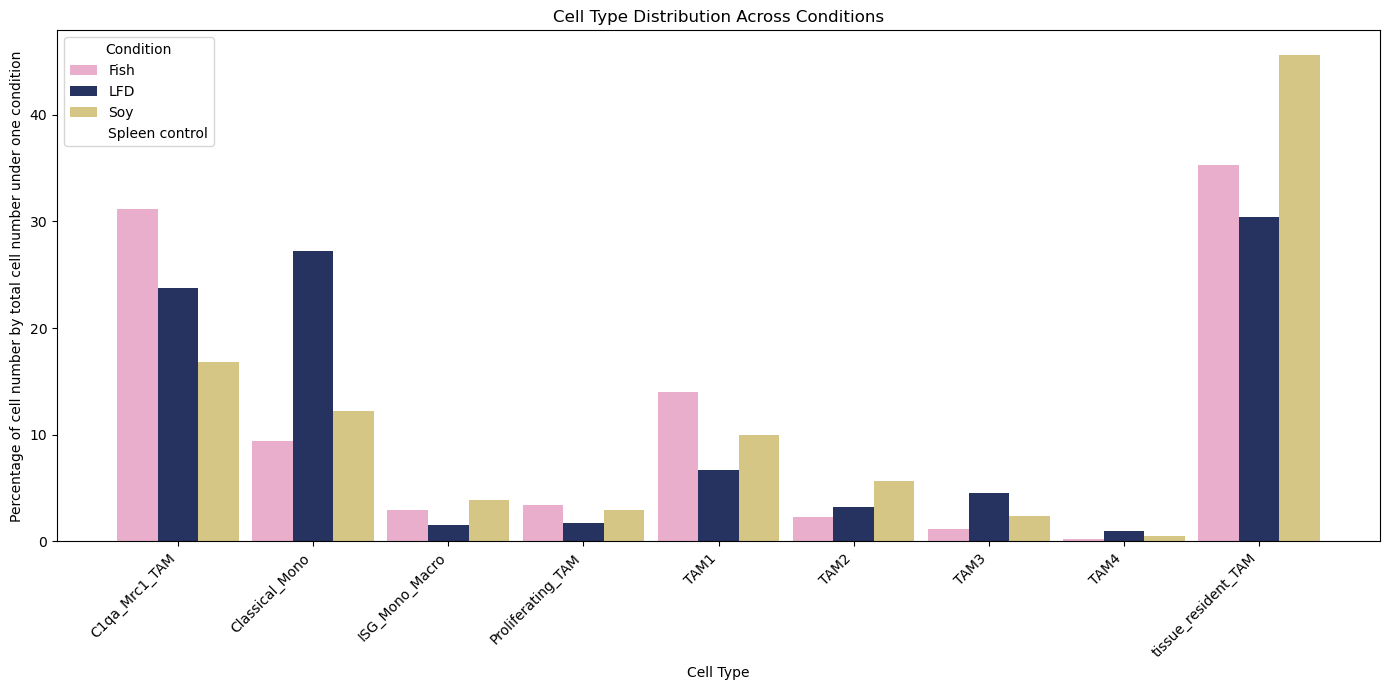

In [33]:
distribution_barplot(tamrna,"TAMcelltype_V2","condition")

DataFrame saved to /data/msun/projects/Stephen/PDAC_scRNA/02_difference/cell_distribution/celltype_bycondition_9.csv


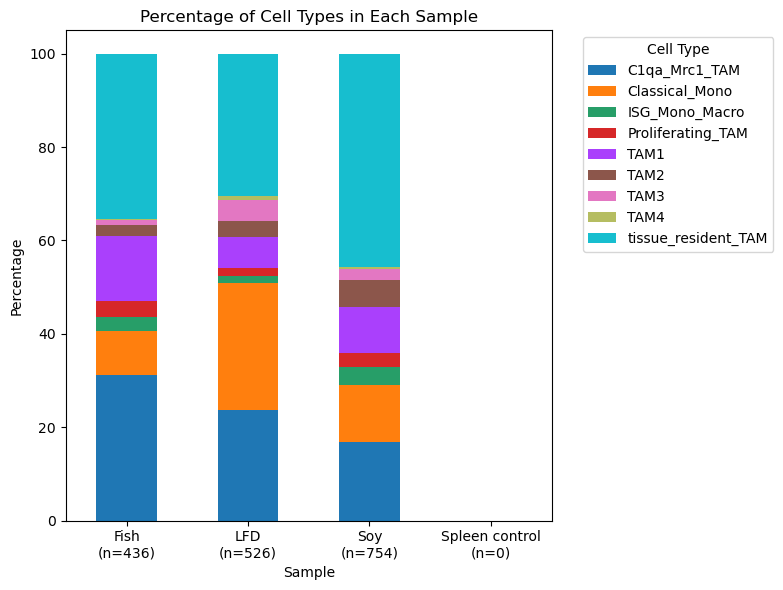

In [34]:
distribution_stackedbar(tamrna, sample_col = "condition",celltype_col = "TAMcelltype_V2")

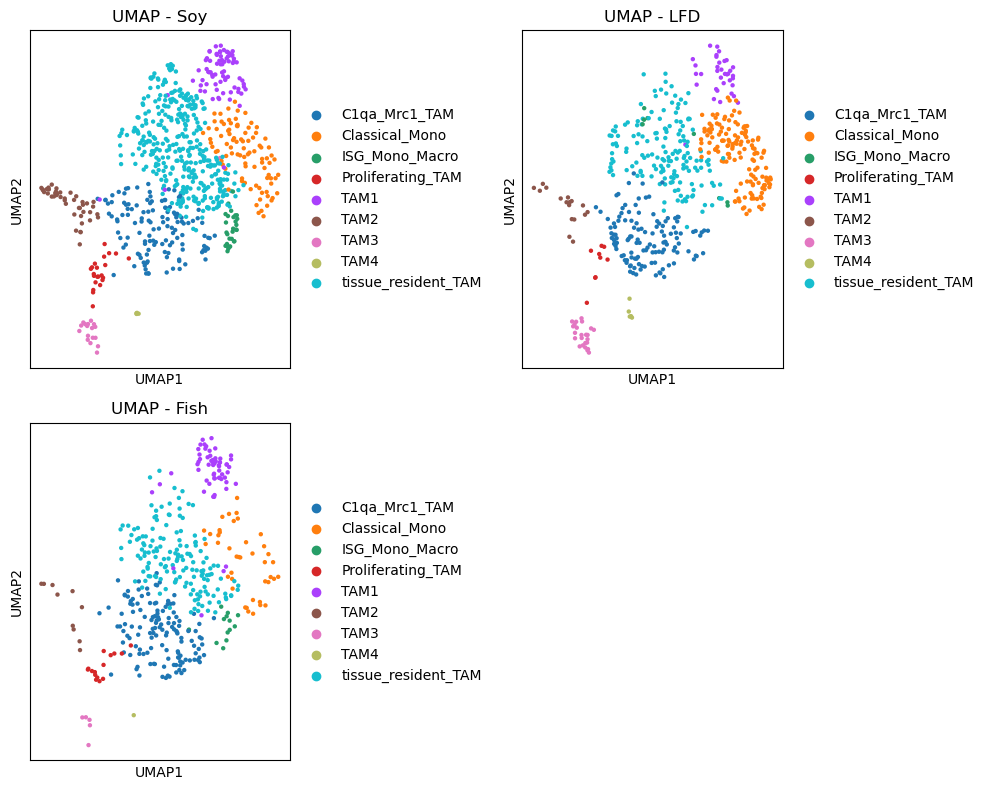

In [35]:
split_plots(tamrna, n_cols=2, sample_col = "condition",celltype_col = "TAMcelltype_V2",ptsize=40,figsize=(10, 8))